<a href="https://colab.research.google.com/github/BlaiseMarvin/FaceRecognitionPaymentSystem/blob/main/FaceNetTrainingArcFaceLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RE-TRAINING THE FACENET MODEL USING BLACK-FACES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## The Arcface loss class

In [2]:
import math as m

import numpy as np
from tqdm import tqdm
import math
import os

import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import layers
from tensorflow.keras import Model 


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# Original paper: https://arxiv.org/pdf/1801.07698.pdf
# Original implementation: https://github.com/deepinsight/insightface
# Adapted from tensorflow implementation: https://github.com/luckycallor/InsightFace-tensorflow



class ArcFace(Layer):
    '''Custom Keras layer implementing ArcFace including:
    1. Generation of embeddings
    2. Loss function
    3. Accuracy function
    '''

    def __init__(self, output_dim, class_num, margin=0.5, scale=64., **kwargs):
        self.output_dim = output_dim
        self.class_num = class_num
        self.margin = margin
        self.s = scale

        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        self.mm = self.sin_m * margin
        self.threshold = tf.math.cos(tf.constant(m.pi) - margin)
        super(ArcFace, self).__init__(**kwargs)


    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.class_num),
                                      initializer='glorot_normal',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this at the end


    def call(self, x):
        embeddings = tf.nn.l2_normalize(x, axis=1, name='normed_embeddings')
        weights = tf.nn.l2_normalize(self.kernel, axis=0, name='normed_weights')
        cos_t = tf.matmul(embeddings, weights, name='cos_t')
        return cos_t


    def get_logits(self, labels, y_pred):
        cos_t = y_pred
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, self.cos_m), tf.multiply(sin_t, self.sin_m), name='cos_mt')
        cond_v = cos_t - self.threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
        keep_val = self.s*(cos_t - self.mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)
        mask = tf.one_hot(labels, depth=self.class_num, name='one_hot_mask')
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
        return output


    def loss(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return loss


    def accuracy(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        accuracy = categorical_accuracy(y_true=labels, y_pred=logits)
        return accuracy
    

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



In [5]:
import os
from os import listdir

path="/content/drive/MyDrive/Extracted/Training/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)




Name:  Vanny count:  38
Name:  Salvador count:  48
Name:  Sandra count:  39
Name:  Samson count:  68
Name:  Peterson count:  44
Name:  Pesh count:  58
Name:  Raymond count:  21
Name:  Owor count:  55
Name:  Renal count:  26
Name:  Ruth count:  20
Name:  Remuneration count:  71
Name:  Mcvex count:  50
Name:  Namubiru count:  50
Name:  Menk count:  56
Name:  Nduhukire count:  54
Name:  Nabwiso count:  60
Name:  Ntale count:  42
Name:  Nabata count:  48
Name:  Maurice count:  37
Name:  Onyango count:  50
Name:  Mbonye count:  64
Name:  Marcus count:  45
Name:  Katamba count:  40
Name:  Malaika count:  57
Name:  Martha count:  43
Name:  Maritza count:  64
Name:  Lydia count:  79
Name:  Lucky count:  57
Name:  Lynda count:  54
Name:  KenMugabi count:  59
Name:  Katatumba count:  62
Name:  Julian count:  67
Name:  GNL count:  30
Name:  Gamzi count:  30
Name:  Jazmine count:  56
Name:  Karungi count:  51
Name:  Kabuura count:  23
Name:  Kanyomozi count:  79
Name:  Judithiana count:  50
Name: 

In [6]:
import os
from os import listdir

path="/content/drive/MyDrive/Extracted/Validation/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)

Name:  Sandra count:  10
Name:  Salvador count:  10
Name:  Raymond count:  6
Name:  Samson count:  22
Name:  Ruth count:  9
Name:  Pesh count:  13
Name:  Peterson count:  11
Name:  Vanny count:  14
Name:  Renal count:  8
Name:  Remuneration count:  21
Name:  Mbonye count:  13
Name:  Onyango count:  10
Name:  Namubiru count:  9
Name:  Mcvex count:  8
Name:  Owor count:  10
Name:  Nabata count:  22
Name:  Nduhukire count:  8
Name:  Ntale count:  10
Name:  Nabwiso count:  22
Name:  Menk count:  10
Name:  Maurice count:  7
Name:  Lydia count:  11
Name:  KenMugabi count:  14
Name:  Lynda count:  11
Name:  Malaika count:  11
Name:  Marcus count:  9
Name:  Martha count:  9
Name:  Lucky count:  16
Name:  Katatumba count:  20
Name:  Maritza count:  14
Name:  Jazmine count:  9
Name:  Kanyomozi count:  12
Name:  Kansiime count:  7
Name:  Julian count:  14
Name:  Karungi count:  7
Name:  GNL count:  7
Name:  Kabuura count:  8
Name:  Kabareebe count:  10
Name:  Katamba count:  10
Name:  Judithiana 

#### Setting up the Image Data Generator API

In [7]:
#Import shutil first, this package deletes ipnb_checkpoints files that create a ghost class
import shutil
#The next step is to delete every ipynb_checkpoints file created by colab
#shutil.rmtree("/tmp/training/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.
#shutil.rmtree("/tmp/testing/.ipynb_checkpoints")

#specify both the training and validation directories
TRAINING_DIR="/content/drive/MyDrive/Extracted/Training/"
VALIDATION_DIR="/content/drive/MyDrive/Extracted/Validation/"

#Initialize Image Data Generator objects, and rescale the image 
training_datagen=ImageDataGenerator(rescale=1/255)
validation_datagen=ImageDataGenerator(rescale=1/255)

#Create the image generators that create the create the classes for all images uploaded
training_generator=training_datagen.flow_from_directory(TRAINING_DIR,class_mode='categorical',target_size=(160,160), shuffle=False)
validation_generator=validation_datagen.flow_from_directory(VALIDATION_DIR,class_mode='categorical',target_size=(160,160), shuffle=False, batch_size=1)

#Load the facenet model architecture
#model=load_model('/tmp/facenet/facenet_keras.h5')


Found 2906 images belonging to 59 classes.
Found 674 images belonging to 59 classes.


## Loading the facenet Model architecture

In [8]:
model=load_model('/content/drive/MyDrive/facenet_keras (1).h5')
#A summary of the model architecture
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [9]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  426


In [10]:
local_weights_file='/content/drive/MyDrive/facenet_keras_weights.h5'
model.load_weights(local_weights_file)

for layer in model.layers:
  layer.trainable=False

In [11]:
#Specify the last layer from the architecture, that you actually want
last_layer=model.get_layer('Bottleneck')
last_output=last_layer.output

In [12]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [13]:
#Code from arcface repo

#customizable arcface layer
af_layer = ArcFace(output_dim=128, class_num=128, margin=0.5, scale=64.)

arcface_output = af_layer(last_output)
x=layers.Flatten()(arcface_output)
#print(arcface_output)
x = Dropout(rate=0.3)(x)

x=layers.Dense(1024,activation='relu')(arcface_output)

x=layers.Dense(512,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(59,activation='softmax')(arcface_output)

model=Model(model.input,x)
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(multi_label = True), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [14]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001)

In [17]:
checkpoint_filepath= '/content/drive/MyDrive/Extracted/Model'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [18]:
#training for 600 epochs
history=model.fit(training_generator,validation_data=validation_generator,epochs=600,verbose=2, callbacks=[reduce_lr,early,model_checkpoint_callback])

Epoch 1/600
91/91 - 1418s - loss: 4.0775 - accuracy: 0.0262 - auc: 0.4959 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.0576 - val_accuracy: 0.0430 - val_auc: 0.5336 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/600
91/91 - 20s - loss: 4.0550 - accuracy: 0.0406 - auc: 0.5265 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.0391 - val_accuracy: 0.0519 - val_auc: 0.5458 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/600
91/91 - 20s - loss: 4.0351 - accuracy: 0.0506 - auc: 0.5553 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.0205 - val_accuracy: 0.0697 - val_auc: 0.5671 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/600
91/91 - 20s - loss: 4.0143 - accuracy: 0.0678 - auc: 0.5820 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.0017 - val_accuracy: 0.0846 - val_auc: 0.5965 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/600
91/91 - 20s - loss: 3.9950 - accuracy: 0.0867 - auc: 0.6124 - reca

### Lets visualize the output of the training phase

## 413 from 426

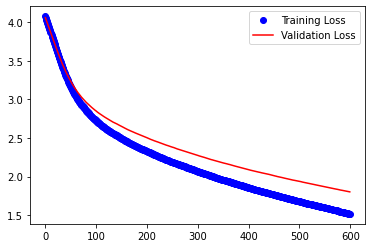

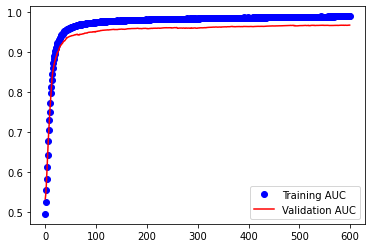

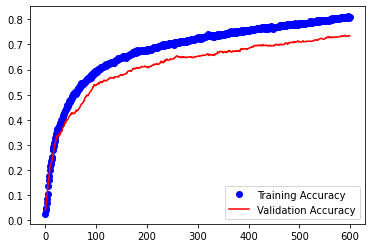

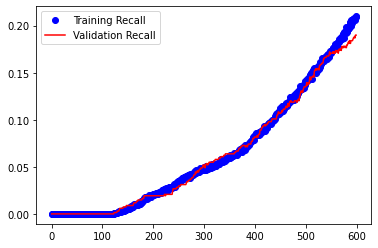

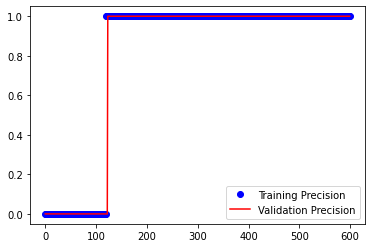

In [19]:
auc=history.history['auc']
val_auc=history.history['val_auc']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

recall=history.history['recall']
val_recall=history.history['val_recall']

precision=history.history['precision']
val_precision=history.history['val_precision']

epochs=range(len(acc))

plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()
plt.show()


plt.plot(epochs,auc,'bo',label="Training AUC")
plt.plot(epochs,val_auc,'r',label="Validation AUC")
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs,recall,'bo',label="Training Recall")
plt.plot(epochs,val_recall,'r',label="Validation Recall")
plt.legend()
plt.show()

plt.plot(epochs,precision,'bo',label="Training Precision")
plt.plot(epochs,val_precision,'r',label="Validation Precision")
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [21]:
filenames = validation_generator.filenames
nb_samples = len(filenames)

In [22]:
predict = model.predict_generator(validation_generator,steps = nb_samples)
y_pred = np.argmax(predict, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [23]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[10  0  0 ...  0  0  0]
 [ 0  5  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  0  4]]


In [24]:
target_names=list(training_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Abenaki       1.00      1.00      1.00        10
        Alex       0.71      0.83      0.77         6
       Aloyo       0.90      0.75      0.82        12
       Apass       0.75      0.33      0.46         9
  Babygloria       0.89      0.80      0.84        10
      Barbie       1.00      0.75      0.86         4
       Becky       0.90      0.90      0.90        10
     Bettina       0.79      0.79      0.79        14
       Brian       0.83      0.71      0.77         7
      Canary       0.83      0.88      0.86        17
       Cindy       0.92      0.71      0.80        17
   Cleopatra       1.00      0.60      0.75        10
      Daniel       1.00      1.00      1.00        17
      Desire       0.86      0.90      0.88        21
       Diana       0.20      0.82      0.32        11
     Dorothy       0.00      0.00      0.00         3
       Farid       0.80      0.94      0.86        17
         GNL       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
!pip install scikit-plot

In [26]:
import scikitplot as skplt
plt.figure(figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

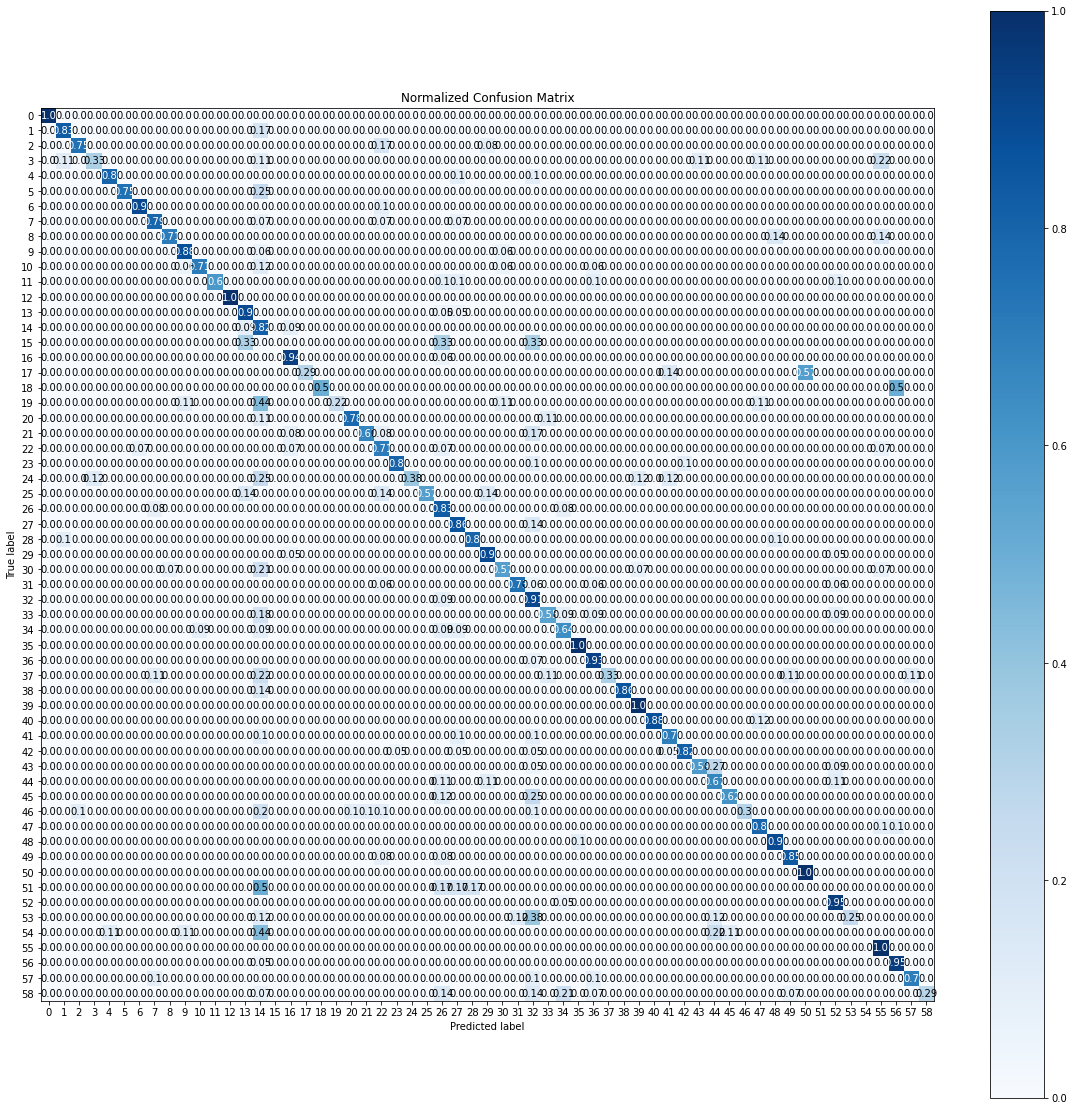

<Figure size 1440x1440 with 0 Axes>

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))
skplt.metrics.plot_confusion_matrix(validation_generator.classes, y_pred, normalize=True,ax=ax)
plt.figure(figsize=(20, 20))
plt.show()

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
model2=Model(model.input,model.layers[-3].output)
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
___________________________________________________________________________________________

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess=tf.Session()
from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["name_of_the_output_node"])
graph_io.write_graph(frozen, '/tmp/session-frozens', 'inference_graph.pb', as_text=False)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as K 
from keras.models import Sequential, Model


sess=tf.Session()
K.set_learning_phase(0)   # Set the learning phase to 0
model = model2 
config = model2.get_config()
#weights = model2.get_weights()
#model = Sequential.from_config(config)
output_node = model2.output.name.split(':')[0]  # We need this in the next step
graph_file = "kerasFacenet.pb" 
ckpt_file = "kerasFacenet.ckpt"
saver = tf.train.Saver(sharded=True)
tf.train.write_graph(sess.graph_def, '', graph_file)
#saver.save(sess, ckpt_file) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


'kerasFacenet.pb'

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

tf.saved_model.save(model2, "/tmp/saved-models")

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model2(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
#print("-" * 50)
#print("Frozen model layers: ")
for layer in layers:
    print(layer)

#print("-" * 50)
#print("Frozen model inputs: ")
#print(frozen_func.inputs)
#print("Frozen model outputs: ")
#print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="/tmp/saved-model",
                  name="facenet-Original-LastLayer.pb",
                  as_text=False)


INFO:tensorflow:Assets written to: /tmp/saved-models/assets
x
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_1a_3x3/Conv2D
model_12/Conv2d_1a_3x3_BatchNorm/scale
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3
model_12/Conv2d_1a_3x3_Activation/Relu
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_2a_3x3/Conv2D
model_12/Conv2d_2a_3x3_BatchNorm/scale
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_2a_3x

'/tmp/saved-model/facenet-Original-LastLayer.pb'